In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e7/sample_submission.csv
/kaggle/input/playground-series-s4e7/train.csv
/kaggle/input/playground-series-s4e7/test.csv


# BEKET NURZAHNOV

# Dataset Description

The dataset for this competition (both train and test) was generated from a deep learning model trained on the Health Insurance Cross Sell Prediction Data dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.

This notebook gives more details about the dataset used for this competition.

## Files

- **train.csv** - The training dataset; `Response` is the binary target.
- **test.csv** - The test dataset; your objective is to predict the probability of `Response` for each row.
- **sample_submission.csv** - A sample submission file in the correct format.

# Data Description

- **id**: Unique ID for the customer
- **Gender**: Gender of the customer
- **Age**: Age of the customer
- **Driving_License**: 0 = Customer does not have a driving license, 1 = Customer already has a driving license
- **Region_Code**: Unique code for the region of the customer
- **Previously_Insured**: 1 = Customer already has Vehicle Insurance, 0 = Customer doesn't have Vehicle Insurance
- **Vehicle_Age**: Age of the vehicle
- **Vehicle_Damage**: 1 = Customer got his/her vehicle damaged in the past, 0 = Customer didn't get his/her vehicle damaged in the past
- **Annual_Premium**: The amount customer needs to pay as premium in the year
- **Policy_Sales_Channel**: Anonymized code for the channel of outreaching to the customer, e.g., different agents, over mail, over phone, in person, etc.
- **Vintage**: Number of days the customer has been associated with the company
- **Response**: 1 = Customer is interested, 0 = Customer is not interested

# IMPORT LIBRARIES

In [2]:
!pip install skimpy

  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.9.0
    Uninstalling typing_extensions-4.9.0:
      Successfully uninstalled typing_extensions-4.9.0
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.1.5
    Uninstalling typeguard-4.1.5:
      Successfully uninstalled typeguard-4.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.4.1 requires cubinlinker, which is not installed.
cudf 24.4.1 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.4.1 requires ptxcompiler, which is not installed.
cuml 24.4.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 24.4.1 requires cupy-cuda11x>=12.0.0, which is not installed.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have di

In [3]:
import pandas as pd
import numpy as np
from scipy.stats import friedmanchisquare

from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, RidgeClassifierCV
from sklearn.inspection import PartialDependenceDisplay
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.metrics import *
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from category_encoders import OneHotEncoder, TargetEncoder

import warnings
from sklearn.base import clone
from sklearn.pipeline import Pipeline, make_pipeline
import seaborn as sns
import skimpy

In [4]:
train = pd.read_csv("/kaggle/input/playground-series-s4e7/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s4e7/test.csv")

In [8]:
train.head(3)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0


In [9]:
test.head(3)

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,11504798,Female,20,1,47.0,0,< 1 Year,No,2630.0,160.0,228
1,11504799,Male,47,1,28.0,0,1-2 Year,Yes,37483.0,124.0,123
2,11504800,Male,47,1,43.0,0,1-2 Year,Yes,2630.0,26.0,271


In [5]:
print(train.shape)
print(test.shape)

(11504798, 12)
(7669866, 11)


In [6]:
print(train.isna().sum())
print(test.isna().sum())

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64
id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
dtype: int64


In [7]:
print(train.duplicated().any())
print(test.duplicated().any())

False
False


In [10]:
train.drop(columns = ["id"], inplace = True)
test.drop(columns = ["id"], inplace = True)

# DESCRIPTIVE STATISTICS

In [11]:
skimpy.skim(train)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│           Data Summary                 Data Types                                                               │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                        │
│ ┃ dataframe         ┃ Values   ┃ ┃ Column Type ┃ Count ┃                                                        │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                        │
│ │ Number of rows    │ 11504798 │ │ int64       │ 5     │                                                        │
│ │ Number of columns │ 11       │ │ string      │ 3     │                                                        │
│ └───────────────────┴──────────┘ │ float64     │ 3     │                                                        │
│                                  └─────────────┴───────┘                                                        │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name            ┃ NA  ┃ NA %  ┃ mean   ┃ sd       ┃ p0    ┃ p25   ┃ p50   ┃ p75   ┃ p100   ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━┩  │
│ │ Age                    │   0 │     0 │  38.38 │    14.99 │    20 │    24 │    36 │    49 │     85 │ ▇▃▅▂▁  │  │
│ │ Driving_License        │   0 │     0 │  0.998 │  0.04443 │     0 │     1 │     1 │     1 │      1 │      ▇ │  │
│ │ Region_Code            │   0 │     0 │  26.42 │    12.99 │     0 │    15 │    28 │    35 │     52 │ ▃▂▁▇▃▂ │  │
│ │ Previously_Insured     │   0 │     0 │  0.463 │   0.4986 │     0 │     0 │     0 │     1 │      1 │ ▇    ▇ │  │
│ │ Annual_Premium         │   0 │     0 │  30460 │    16450 │  2630 │ 25280 │ 31820 │ 39450 │ 540200 │   ▇    │  │
│ │ Policy_Sales_Channel   │   0 │     0 │  112.4 │    54.04 │     1 │    29 │   151 │   152 │    163 │ ▃   ▃▇ │  │
│ │ Vintage                │   0 │     0 │  163.9 │    79.98 │    10 │    99 │   166 │   232 │    299 │ ▅▇▇▇▇▇ │  │
│ │ Response               │   0 │     0 │  0.123 │   0.3284 │     0 │     0 │     0 │     0 │      1 │ ▇    ▁ │  │
│ └────────────────────────┴─────┴───────┴────────┴──────────┴───────┴───────┴───────┴───────┴────────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                   ┃ NA     ┃ NA %       ┃ words per row               ┃ total words            ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ Gender                        │      0 │          0 │                           1 │               11504798 │  │
│ │ Vehicle_Age                   │      0 │          0 │                         2.5 │               28531716 │  │
│ │ Vehicle_Damage                │      0 │          0 │                           1 │               11504798 │  │
│ └───────────────────────────────┴────────┴────────────┴─────────────────────────────┴────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

## Dataset Summary

The dataset contains the following columns with their respective statistics:

- **id**
  - **NA:** 0
  - **Mean:** 5,752,000
  - **Standard Deviation:** 3,321,000
  - **Distribution:** Uniform

- **Age**
  - **NA:** 0
  - **Mean:** 38.38
  - **Standard Deviation:** 14.99
  - **Distribution:** Slight right skew

- **Region_Code**
  - **NA:** 0
  - **Mean:** 26.42
  - **Standard Deviation:** 12.99
  - **Distribution:** Multi-modal with peaks

- **Annual_Premium**
  - **NA:** 0
  - **Mean:** 30,460
  - **Standard Deviation:** 16,450
  - **Distribution:** Highly right-skewed
  - **Observation:** High standard deviation indicates significant variability in annual premium values. 

- **Policy_Sales_Channel**
  - **NA:** 0
  - **Mean:** 112.4
  - **Standard Deviation:** 54.04
  - **Distribution:** Peaks around 29, 151, and 152
  - **Observation:** The presence of peaks at specific points suggests the existence of a few dominant sales channels.

- **Vintage**
  - **NA:** 0
  - **Mean:** 163.9
  - **Standard Deviation:** 79.98
  - **Distribution:** Uniform distribution with some peaks

- **Response**
  - **NA:** 0
  - **Mean:** 0.123
  - **Standard Deviation:** 0.3284
  - **Distribution:** Highly imbalanced with a majority of responses being 0
  - **Observation:** Imbalance in the response variable may require special handling during model training.

### Anomalies
- **Annual_Premium:** The high standard deviation suggests a wide range of values, which may indicate the presence of outliers or varying premium plans.
- **Policy_Sales_Channel:** Peaks at specific values may require investigation to understand the sales distribution better.

Overall, the dataset has no missing values and the distributions indicate some variability, particularly in `Annual_Premium` and `Policy_Sales_Channel`.

# EDA

### Distribution of Categorical Features

In [12]:
def column_distribution(data, col_name):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Create Count plot
    sns.countplot(data=data, x=col_name, ax=axes[0])
    axes[0].set_title(f'Count of {col_name}')
    axes[0].set_xlabel(col_name)
    axes[0].set_ylabel('Count')
    
    # Create Pie Chart
    value_counts = data[col_name].value_counts()
    axes[1].pie(value_counts, labels=value_counts.index, startangle=90, autopct='%1.1f%%')
    axes[1].set_title(f'Distribution of {col_name}')
    
    plt.tight_layout()
    plt.show()

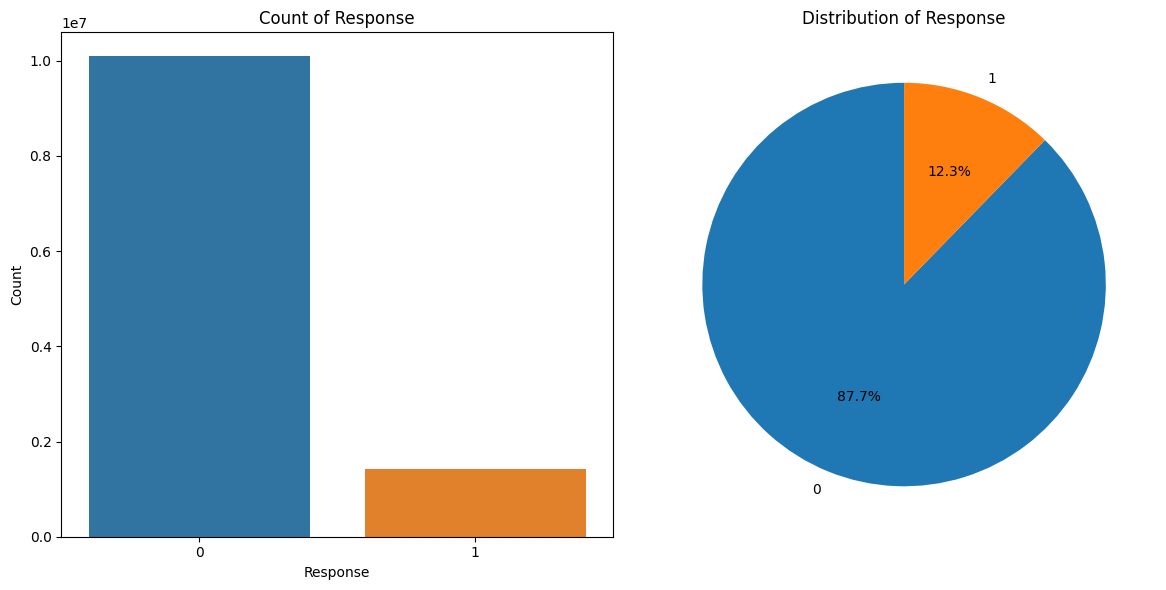

In [13]:

column_distribution(train, 'Response')

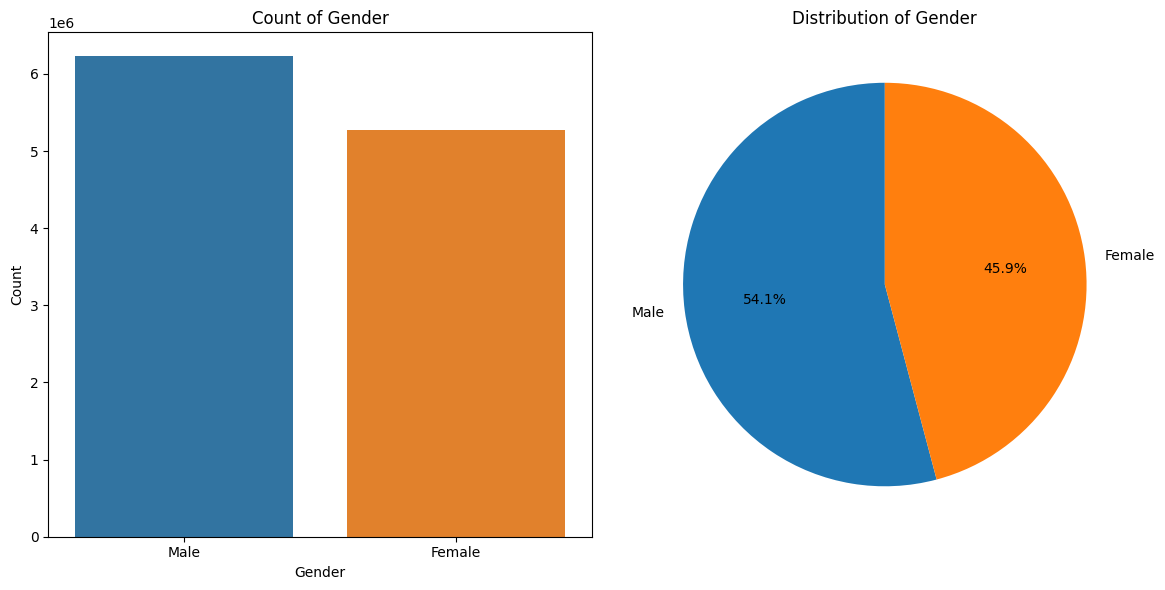

In [14]:
column_distribution(train, 'Gender')

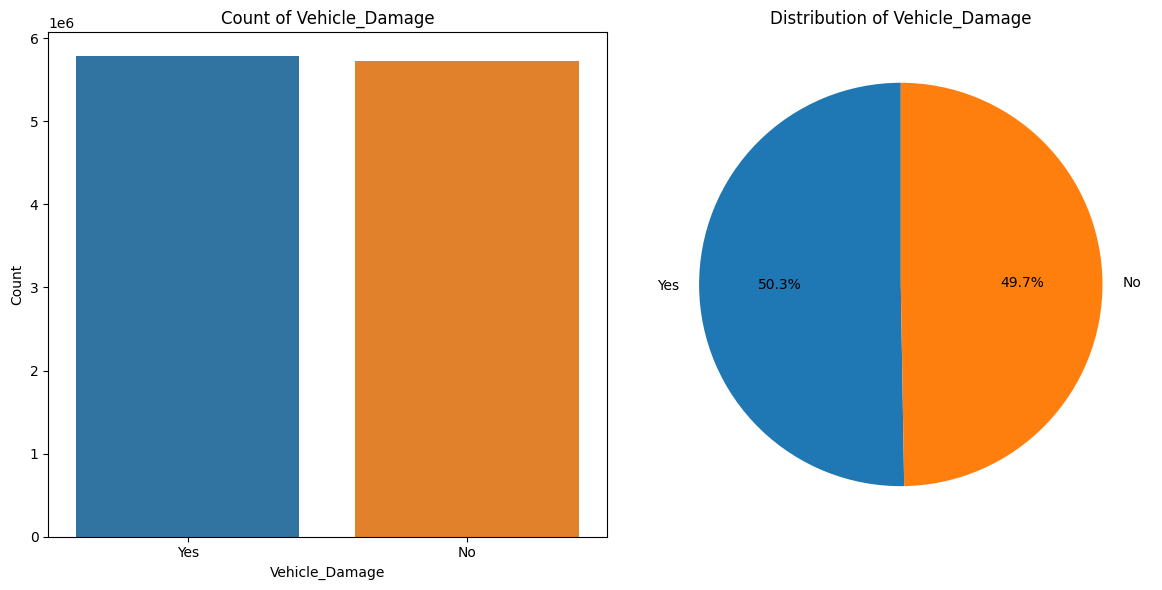

In [15]:
column_distribution(train, 'Vehicle_Damage')

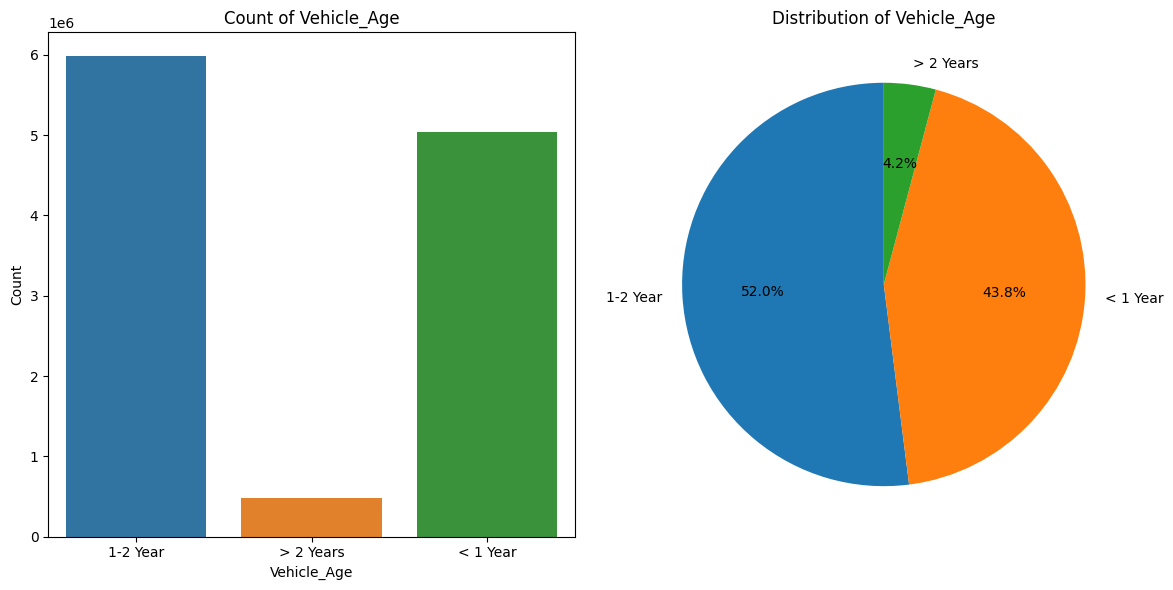

In [16]:
column_distribution(train, 'Vehicle_Age')

### Distribution of Numerical Features

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

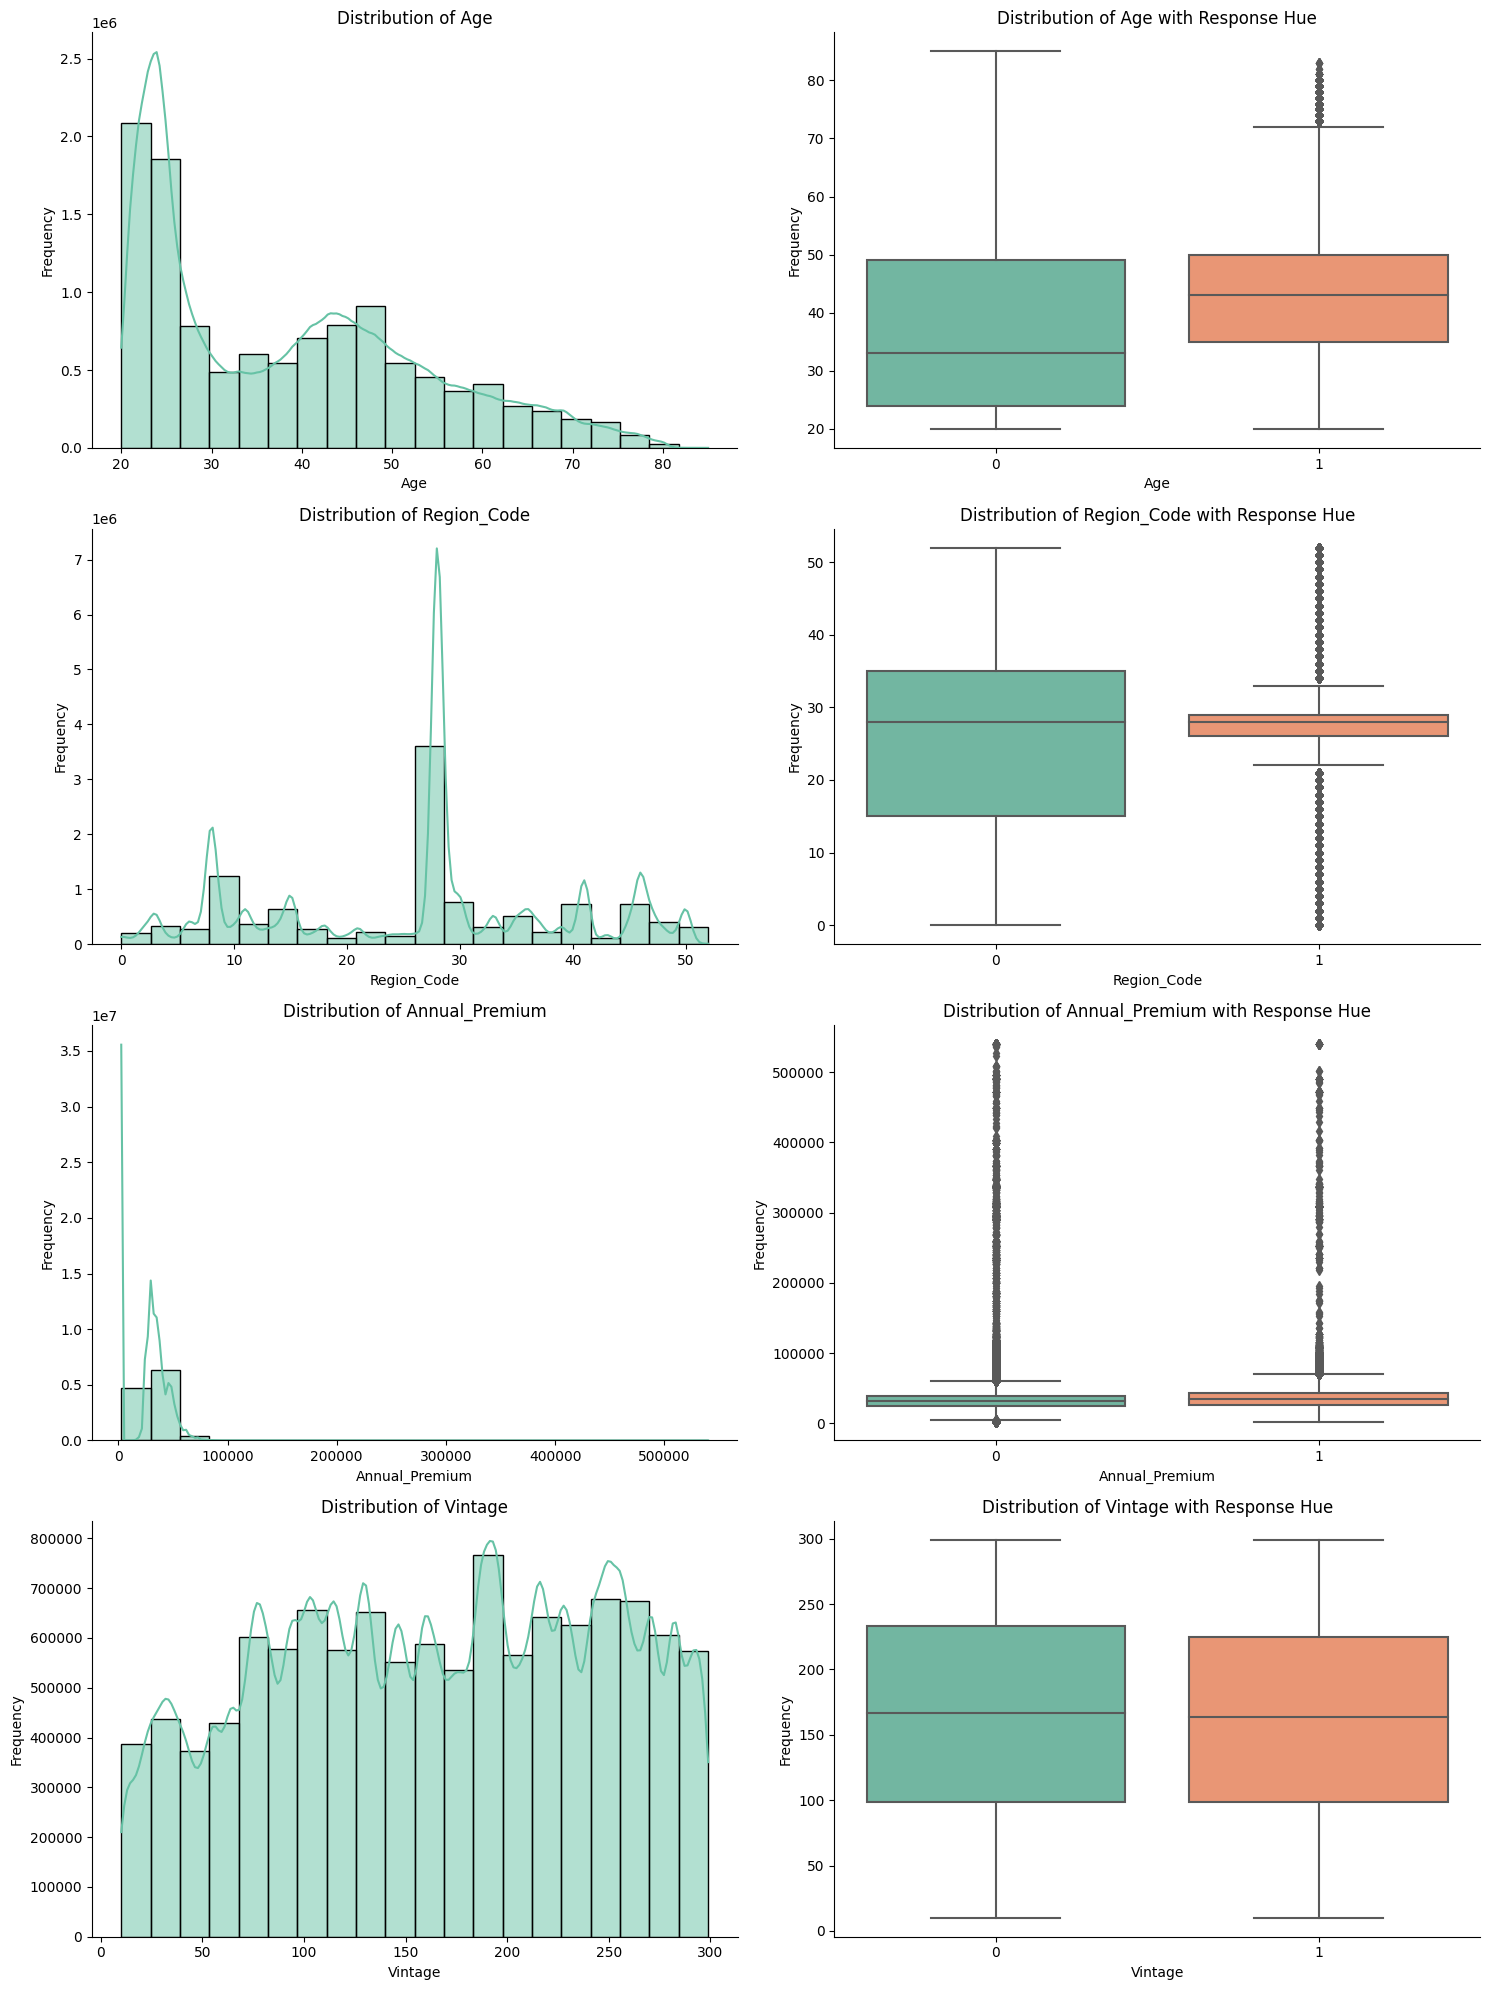

In [20]:

# Select numerical features for visualization
numerical_cols = ['Age', 'Region_Code', 'Annual_Premium', 'Vintage']

# Create subplots with 4 rows and 2 columns
fig, axes = plt.subplots(4, 2, figsize=(15, 20))

# Iterate over each selected column
for i, column in enumerate(numerical_cols):
    # Plot without hue on the left
    sns.histplot(data=train, x=column, kde=True, bins=20, ax=axes[i, 0])
    axes[i, 0].set_title(f'Distribution of {column}')
    axes[i, 0].set_xlabel(column)
    axes[i, 0].set_ylabel('Frequency')

    # Plot with hue on the right
    sns.boxplot(data=train, y=column, x='Response', ax=axes[i, 1])
    axes[i, 1].set_title(f'Distribution of {column} with Response Hue')
    axes[i, 1].set_xlabel(column)
    axes[i, 1].set_ylabel('Frequency')

sns.despine()
plt.tight_layout()
plt.show()

### Data Analysis Summary

1. **Correlation Analysis**:
   - There is a negative correlation of **-0.59** between the **Policy Sales Channel** and **Age**.
   - No strong correlation with the **Response** variable.
   - The highest correlation with the **Response** variable is with the **Previously Insured** feature, which stands at **-0.35**.

2. **Distribution Observations**:
   - The **Age** variable exhibits a **right-skewed distribution**.
   - The **Annual Premium** has a **long right tail**, indicating the presence of outliers.
   - The **Vintage** variable follows a **uniform distribution**.

3. **Demographic Insights**:
   - **Older individuals** show a higher **Response** rate.
   - There is a slight predominance of **men** over **women** in the dataset.
   - The **Vehicle Damage** variable is evenly split, with **50% showing damage** and **50% not showing damage**.

4. **Response Variable Imbalance**:
   - The **Response** variable is imbalanced, with **87.7%** of instances being **0** and only **12.3%** being **1**.


# PREPROCESSING

In [21]:
cat_columns = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']

train_encoded = pd.get_dummies(train, columns = cat_columns, drop_first=True, dtype=int)
test_encoded = pd.get_dummies(test, columns = cat_columns, drop_first=True, dtype=int)

In [22]:
X = train_encoded.drop(columns = ["Response"], axis = 1)
y = train_encoded["Response"]

# NORMALIZATION

In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)


# TRAIN TEST SPLIT

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=42)


In [29]:
print(X_train.shape)
print(X_test.shape)

(8053358, 11)
(3451440, 11)


# MODELING

In [30]:
model0 = XGBClassifier()
model0.fit(X_train, y_train)
pr = model0.predict(X_test)
print(roc_auc_score(y_test, pr))

0.5409840305051081


During the training of the XGBoost model, we observed that the ROC AUC score was 0.5409840305051081, which indicates a relatively low performance in distinguishing between classes. To address this issue, we will incorporate the `class_weight` parameter to mitigate any imbalance in class distribution. Additionally, we will employ cross-validation to ensure robust evaluation of the model's performance.



In [46]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# Constants
xgb_params = {    
        'max_depth': 13, 
        'min_child_weight': 5,
        'learning_rate': 0.02,
        'colsample_bytree': 0.6,         
        'max_bin': 3000, 
        'n_estimators': 1500 
}

# Initialize the XGBoost classifier with specified hyperparameters
model = XGBClassifier(**xgb_params, class_weight='balanced')

# Fit the classifier to the training data
XGB_model = model.fit(X_train, y_train)

# Make predictions on the test data
predictions = XGB_model.predict_proba(X_test)[:,1]

# Print the validation area under the curve
print("Validation Area Under the Curve (AUC): ", roc_auc_score(y_test, predictions))

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [11:07:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Validation Area Under the Curve (AUC):  0.8856658684388885


# SUBMISSION

In [47]:
sample = pd.read_csv("/kaggle/input/playground-series-s4e7/sample_submission.csv")

In [48]:
test_scaled = scaler.transform(test_encoded)

pred_test = model.predict_proba(test_scaled)[:, 1]

In [51]:
new_test = pd.read_csv("/kaggle/input/playground-series-s4e7/test.csv")
test_ids = new_test['id']

In [52]:
result = pd.DataFrame({'id' : test_ids, 'Response' : pred_test.flatten()},
                     columns = ['id', 'Response'])


In [53]:
result

,id,Response
0,11504798,0.002843
1,11504799,0.518018
2,11504800,0.232757
3,11504801,0.000097
4,11504802,0.068208
...,...,...
7669861,19174659,0.192321
7669862,19174660,0.000067
7669863,19174661,0.000289
7669864,19174662,0.566836


In [54]:
sample

,id,Response
0,11504798,0.5
1,11504799,0.5
2,11504800,0.5
3,11504801,0.5
4,11504802,0.5
...,...,...
7669861,19174659,0.5
7669862,19174660,0.5
7669863,19174661,0.5
7669864,19174662,0.5


In [57]:
res = (sample['Response'] == result['Response']).mean()
print(1 - res)

0.9999998696196257


# Accuracy is 0.9999998696196257